In [ ]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

In [ ]:
# Nomrmalize data
from sklearn.preprocessing import MinMaxScaler

# Add production data to X_train and X_test
X_train['Limonene'] = y_train
X_test['Limonene'] = y_test

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[INPUT_VARS+RESPONSE_VARS], index=DBTL_A)
X_test = pd.DataFrame(X_test, columns=[INPUT_VARS+RESPONSE_VARS], index=DBTL_B)

print('Normalization complete...')

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam

def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = 50
latent_dim = 5

# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
x = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# use the reparameterization trick and get the output from the sample() function
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, z, name='encoder')

# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
outputs = Dense(original_dim)(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')

# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

opt = Adam(learning_rate=0.0001)
vae_model.compile(optimizer=opt, loss=vae_loss)
results = vae_model.fit(X_train, X_train, shuffle=True, epochs=10000, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt
# Plot learning curve
plt.plot(results.history['loss'])
plt.title('Learning Curve')
plt.ylabel('Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

In [ ]:
# Get the latent representation of the input data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

In [ ]:
X_train_encoded = pd.DataFrame(X_train_encoded, index=df_A.index, columns=[f"z_{i}" for i in range(latent_dim)])
X_test_encoded = pd.DataFrame(X_test_encoded, index=df_B.index, columns=[f"z_{i}" for i in range(latent_dim)])

X_train_encoded['Limonene'] = y_train
X_test_encoded['Limonene'] = y_test

In [ ]:
# Plot 3D plot of the latent representation
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_encoded['z_0'], X_train_encoded['z_1'], X_train_encoded['z_2'], color='blue', alpha=0.4)
ax.scatter(X_test_encoded['z_0'], X_test_encoded['z_1'], X_test_encoded['z_2'], color='red', alpha=0.4)
# Write the index of the points if Limonene is greater than 0.5
for i, txt in enumerate(X_train_encoded.index):
    if X_train_encoded['Limonene'][i] > 80:
        ax.text(X_train_encoded['z_0'][i], X_train_encoded['z_1'][i], X_train_encoded['z_2'][i], txt, color='black')
for i, txt in enumerate(X_test_encoded.index):
    if X_test_encoded['Limonene'][i] > 80:
        ax.text(X_test_encoded['z_0'][i], X_test_encoded['z_1'][i], X_test_encoded['z_2'][i], txt, color='black')
ax.set_xlabel('z_0')
ax.set_ylabel('z_1')
ax.set_zlabel('z_2')
plt.title('Latent representation of the input data')
plt.show()

In [ ]:
# Perform PCA on the latent representation
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_encoded.drop(columns='Limonene'))
X_test_pca = pca.transform(X_test_encoded.drop(columns='Limonene'))

X_train_pca = pd.DataFrame(X_train_pca, index=df_A.index, columns=['PC1', 'PC2'])
X_test_pca = pd.DataFrame(X_test_pca, index=df_B.index, columns=['PC1', 'PC2'])

X_train_pca['Limonene'] = y_train
X_test_pca['Limonene'] = y_test

# Plot 2D plot of the latent representation
plt.scatter(X_train_pca['PC1'], X_train_pca['PC2'], color='blue', alpha=0.4)
plt.scatter(X_test_pca['PC1'], X_test_pca['PC2'], color='red', alpha=0.4)
# Write the index of the points if Limonene is greater than ...
for i, txt in enumerate(X_train_pca.index):
    if X_train_pca['Limonene'][i] > 80:
        plt.text(X_train_pca['PC1'][i], X_train_pca['PC2'][i], txt, color='black')
for i, txt in enumerate(X_test_pca.index):
    if X_test_pca['Limonene'][i] > 80:
        plt.text(X_test_pca['PC1'][i], X_test_pca['PC2'][i], txt, color='black')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of the latent representation of the input data')
plt.show()

In [ ]:
# Perform UMAP in latent space
import umap

umap_model = umap.UMAP(n_components=2)
X_train_umap = umap_model.fit_transform(X_train_encoded.drop(columns='Limonene'))
X_test_umap = umap_model.transform(X_test_encoded.drop(columns='Limonene'))

X_train_umap = pd.DataFrame(X_train_umap, index=df_A.index, columns=['UMAP1', 'UMAP2'])
X_test_umap = pd.DataFrame(X_test_umap, index=df_B.index, columns=['UMAP1', 'UMAP2'])

X_train_umap['Limonene'] = y_train
X_test_umap['Limonene'] = y_test

# Plot 2D plot of the latent representation
plt.scatter(X_train_umap['UMAP1'], X_train_umap['UMAP2'], color='blue', alpha=0.4)
plt.scatter(X_test_umap['UMAP1'], X_test_umap['UMAP2'], color='red', alpha=0.4)
# Write the index of the points if Limonene is greater than ...
for i, txt in enumerate(X_train_umap.index):
    if X_train_umap['Limonene'][i] > 60:
        plt.text(X_train_umap['UMAP1'][i], X_train_umap['UMAP2'][i], txt, color='black')
for i, txt in enumerate(X_test_umap.index):
    if X_test_umap['Limonene'][i] > 60:
        plt.text(X_test_umap['UMAP1'][i], X_test_umap['UMAP2'][i], txt, color='black')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('UMAP of the latent representation of the input data')
plt.show()


In [ ]:
target_mean = X_train_encoded.sort_values(by='Limonene', ascending=False).head(10).drop('Limonene', axis=1).mean().values
target_std_dev = 0.1

# Generate new samples
z = []
for i in range(10000):
    epsilon = np.random.normal(0, 1, latent_dim)
    zz = target_mean + np.exp(0.5 * target_std_dev) * epsilon
    z.append(zz)

# Transrom z from list of arrays to numpy array
z = np.array(z)
generated_samples = decoder.predict(z)
generated_samples = scaler.inverse_transform(generated_samples)
generated_samples = pd.DataFrame(generated_samples, columns=[INPUT_VARS+RESPONSE_VARS])
generated_samples.sort_values(by=('Limonene',), ascending=False, inplace=True)
generated_samples

In [ ]:
df_B

In [ ]:
X_test_pred = pd.DataFrame(vae_model.predict(X_test), columns=X_train.columns).head()
X_test_pred = pd.DataFrame(scaler.inverse_transform(X_test_pred), columns=X_train.columns)
X_test_pred

# Model selection (NCV)

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# ## Uncomment to run model selection
# modelSelection(X_train, y_train)

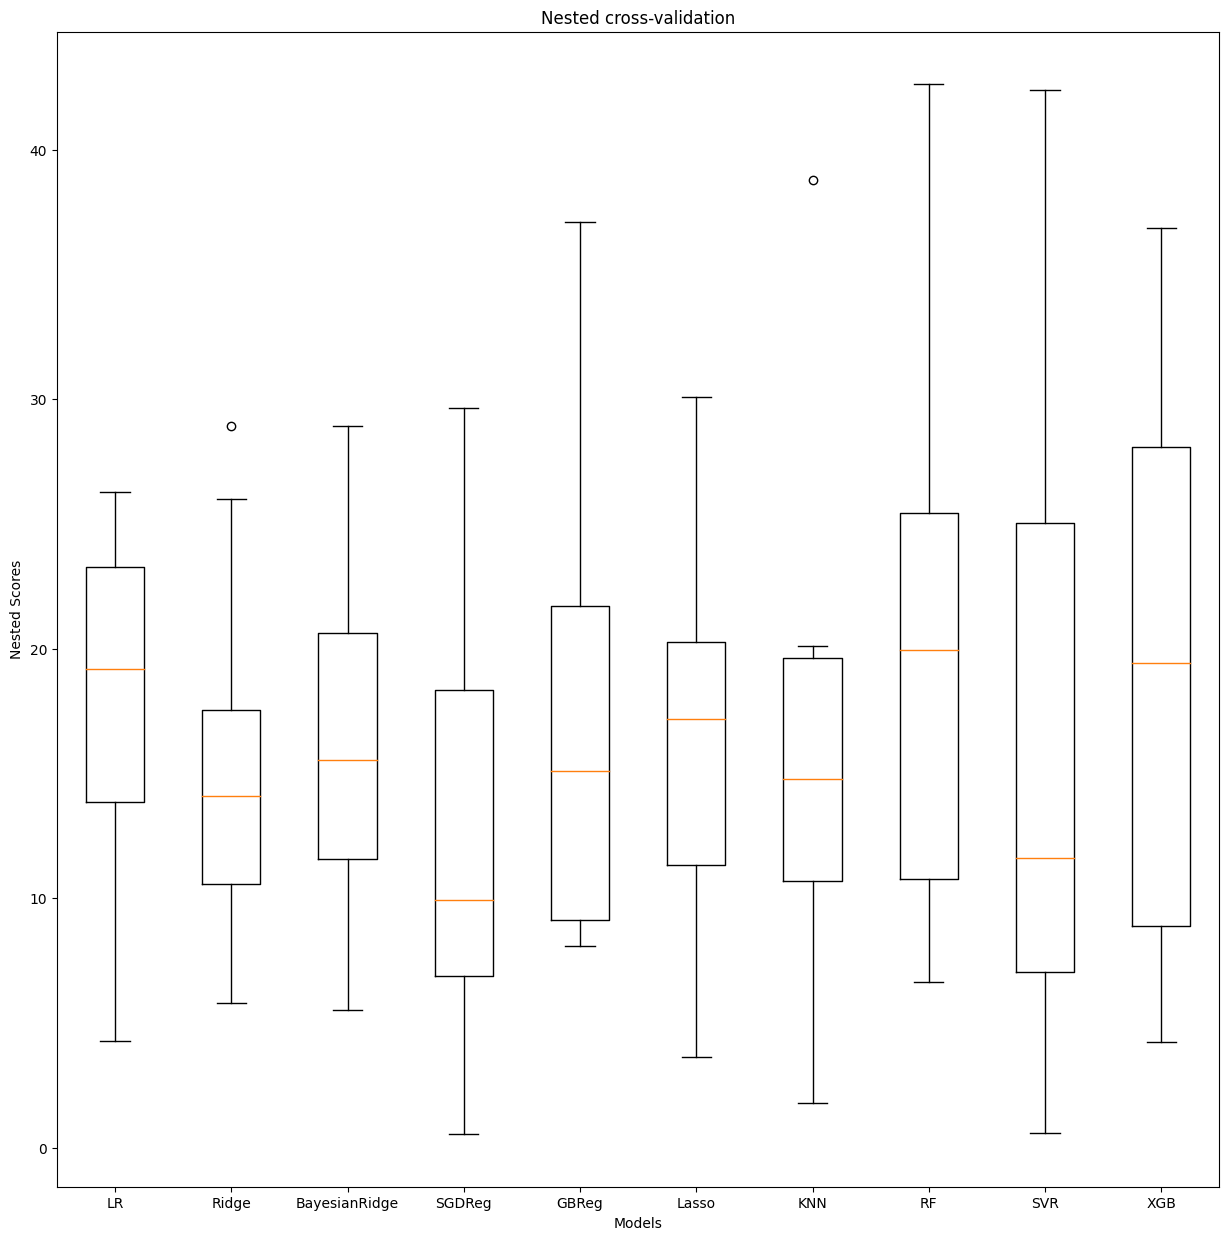

# ML training (Optuna)

In [ ]:
# import optuna
# from sklearn.svm import SVR
# from sklearn.model_selection import cross_val_score


# def objective(trial):
#     # Define the hyperparameters to optimize
#     C = trial.suggest_loguniform("C", 0.01, 100)
#     epsilon = trial.suggest_loguniform("epsilon", 0.01, 1)
#     gamma = trial.suggest_loguniform("gamma", 0.001, 1)
#     kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
#     degree = trial.suggest_int("degree", 2, 5)

#     # Create the SVR model with the hyperparameters
#     model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=degree)
#     scores = cross_val_score(
#         model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error"
#     )
#     return -scores.mean()


# # Create the study object and optimize the objective function
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100)
# best_params = study.best_params
# final_model = SVR(**best_params)
# final_model.fit(X_train, y_train)

In [ ]:
import optuna
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
    l1_ratio = trial.suggest_uniform("l1_ratio", 0, 1)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "optimal", "invscaling"])
    eta0 = trial.suggest_loguniform("eta0", 1e-5, 1e-1)
    model = SGDRegressor(alpha=alpha, l1_ratio=l1_ratio, learning_rate=learning_rate, eta0=eta0)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    return -scores.mean()

# Create the study object and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=800)
best_params = study.best_params
final_model = SGDRegressor(**best_params)
final_model.fit(X_train, y_train)


In [ ]:
# # Pickle save model
# with open("../models/limonene_model.pkl", "wb") as f:
#     pickle.dump(final_model, f)

# Model evaluation (Bootstrap)

In [ ]:
# pickle load model
with open("../models/limonene_model.pkl", "rb") as f:
    final_model = pickle.load(f)

In [ ]:
def bootstrap(X, y, model: object, n: int = 100):
    mse_values = []
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
        mse_values.append(mean_squared_error(y_test, y_pred))
    return mae_values, mse_values

mae_values, mse_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
print(f"Bootstraped Mean(MSE) = {np.mean(mse_values)}")

print(f"Bootstraped std(MAE) = {np.std(mae_values)}")
print(f"Bootstraped std(MSE) = {np.std(mse_values)}")

final_model.fit(X_train, y_train)

# Explainable AI 

In [ ]:
import shap
import matplotlib.pyplot as plt


def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(final_model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = final_model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(8, 4))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(8, 4))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

In [ ]:
idx=0
shap.decision_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[idx].values, 
                   INPUT_VARS)

print(shap_df[['pred', 'true']].iloc[idx])

In [ ]:
feature = "KIME_YEAST"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=True)
shap_scatter(feature)

In [ ]:
shap.force_plot(shap_explainer.expected_value, 
                   shap_df[INPUT_VARS].iloc[2].values, 
                   features=INPUT_VARS,
                   matplotlib=True, show=True)

# Lime

In [ ]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

In [ ]:
sample_df

In [ ]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=INPUT_VARS,  
                                                   verbose=True, mode='regression')
                                                   
i = 22
exp = explainer.explain_instance(X_train.values[i], final_model.predict)
exp.show_in_notebook(show_table=True, show_all=True)
exp.as_list()
exp.as_pyplot_figure();

# Sampling

Create new `sampling bounds`, to generate/recommend new strain designs.

In [ ]:
bounds

In [ ]:
df_B 

In [ ]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 5.34 # 9.58
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 1.95
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = 0.28 # bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 0.75 # bounds["Q9FD87_STAAU"].loc["max"]

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = 1.27 #bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 2.51

sampling_bounds["Q9FD86_STAAU"].loc["min"] = 0.19 # bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.78 # bounds["Q9FD86_STAAU"].loc["max"]

sampling_bounds["MVD1_YEAST"].loc["min"] = 1.74 # bounds["MVD1_YEAST"].loc["min"]
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = bounds["ERG8_YEAST"].loc["min"]
sampling_bounds["ERG8_YEAST"].loc["max"] = bounds["ERG8_YEAST"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["KIME_YEAST"].loc["min"] = bounds["KIME_YEAST"].loc["min"]
sampling_bounds["KIME_YEAST"].loc["max"] = bounds["KIME_YEAST"].loc["max"]


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)

# Counterfactuals (`DiCE`)

In [ ]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:2]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[105, 130],
    permitted_range=bounds_to_dict(sampling_bounds),
    features_to_vary="all",
    # proximity_weight=0.4,
    # diversity_weight=0.8,
    # sparsity_weight=0.4
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=False)

In [ ]:
cf_df = pd.DataFrame()
for i in range(len(e1.cf_examples_list)):
    _ = e1.cf_examples_list[i].final_cfs_df
    # Concatenate the dataframes
    cf_df = pd.concat([cf_df, _], axis=0)

cf_df.sort_values('Limonene', ascending=False, inplace=True)
cf_df.head(10)

In [ ]:
df_B

# PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:10])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [ ]:
final_model.predict(df_B[INPUT_VARS])

In [ ]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)